In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from pydrake.all import (
    ConstantVectorSource,
    DiagramBuilder,
    InverseKinematics,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    PointCloud,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)
from pydrake.multibody import inverse_kinematics
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.trajectories import PiecewisePolynomial

from manipulation import FindResource
from manipulation.meshcat_utils import AddMeshcatTriad, MeshcatPoseSliders
from manipulation.scenarios import AddIiwa, AddWsg, AddMultibodyTriad, MakeManipulationStation, AddRgbdSensors
from manipulation.station import AddPointClouds, load_scenario, MakeHardwareStation
from manipulation.utils import running_as_notebook, ConfigureParser

In [3]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [87]:
meshcat.Delete()

In [53]:
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    robot_sdf_path = "package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf"
    gripper_sdf_path = "package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
    sim_timestep = 1e-3
    plant_robot = MultibodyPlant(sim_timestep)
    parser = Parser(plant=plant_robot)
    parser.AddModelsFromUrl(robot_sdf_path)
    parser.AddModelsFromUrl(gripper_sdf_path)
    plant_robot.WeldFrames(
        frame_on_parent_F=plant_robot.world_frame(),
        frame_on_child_M=plant_robot.GetFrameByName("iiwa_link_0"),
    )
    plant_robot.WeldFrames(
        frame_on_parent_F=plant_robot.GetFrameByName("iiwa_link_7"),
        frame_on_child_M=plant_robot.GetFrameByName("body"),
        X_FM=RigidTransform(
            RollPitchYaw(np.pi / 2, 0, np.pi / 2), np.array([0, 0, 0.114])
        ),
    )
    plant_robot.mutable_gravity_field().set_gravity_vector([0, 0, 0])
    plant_robot.Finalize()

    link_frame_indices = []
    for i in range(8):
        link_frame_indices.append(
            plant_robot.GetFrameByName("iiwa_link_" + str(i)).index()
        )

    return plant_robot, link_frame_indices

def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
    """
    builder = DiagramBuilder()
    scenario = load_scenario(
        filename = "/workspaces/manip-final-project/withcamera.scenarios.yaml",
        scenario_name = "Tennis"
    )
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
    g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    builder.Connect(
        q_traj_system.get_output_port(), station.GetInputPort("iiwa.position")
    )
    builder.Connect(
        g_traj_system.get_output_port(), station.GetInputPort("wsg.position")
    )

    diagram = builder.Build()

    simulator = Simulator(diagram)
    visualizer.StartRecording(False)
    simulator.AdvanceTo(duration)
    visualizer.PublishRecording()

    return simulator, plant

def setup_manipulation_station(bottle=True):
    builder = DiagramBuilder()
    if bottle:
        scenario = load_scenario(
            filename = "/workspaces/manip-final-project/withcamera.scenarios.yaml",
            scenario_name = "Tennis"
        )
    else:
        scenario = load_scenario(
            filename = "/workspaces/manip-final-project/withcamera_nobottle.scenarios.yaml",
            scenario_name = "Tennis"
        )
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

    MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
    builder.Connect(
        wsg_position.get_output_port(), station.GetInputPort("wsg.position")
    )

    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )
    for i in range(6):
        camera_name = f"camera{i}"

        builder.ExportOutput(
            station.GetOutputPort(camera_name + ".rgb_image"), f"rgb_image{i}"
        )
        builder.ExportOutput(
            station.GetOutputPort(camera_name + ".depth_image"), f"depth_image{i}"
        )

        # Add a box for the camera in the environment.
        
        camera_instance = plant.GetModelInstanceByName(camera_name)
        AddMultibodyTriad(
            plant.GetFrameByName("base", camera_instance),
            scene_graph,
            length=0.1,
            radius=0.005,
        )
        # Export the point cloud output.
        builder.ExportOutput(
            to_point_cloud[camera_name].point_cloud_output_port(), f"point_cloud{i}"
        )

    diagram = builder.Build()

    context = plant.CreateDefaultContext()
    gripper = plant.GetBodyByName("body")

    initial_pose = plant.EvalBodyPoseInWorld(context, gripper)

    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01)

    return initial_pose, diagram

initial_pose, diagram = setup_manipulation_station()

In [ ]:
pickup_rpy = RollPitchYaw([-np.pi/2, 0, np.pi/2])
pickup_rotation = RotationMatrix(pickup_rpy)
pickup_position = np.array([0.5, 0, 0.31])
pickup_pose = RigidTransform(pickup_rotation, pickup_position)

up_position = np.array([0.5, 0, 1])
up_pose = RigidTransform(pickup_rotation, up_position)

turn_rpy = RollPitchYaw([-np.pi/2, 0, 0])
turn_rotation = RotationMatrix(turn_rpy)
turn_position = np.array([0, 0.5, 0.5])
turn_pose = RigidTransform(turn_rotation, turn_position)

# load_rpy = RollPitchYaw([-2, 0, 0])
# load_rotation = RotationMatrix(load_rpy)
# load_position = np.array([0, 0.5, 0.5])
# load_pose = RigidTransform(load_rotation, load_position)

# throw_rpy = RollPitchYaw([-1, 0, 0])
# throw_rotation = RotationMatrix(throw_rpy)
# throw_position = np.array([0, 0.5, 0.5])
# throw_pose = RigidTransform(throw_rotation, throw_position)

## Interpolate Pose for entry.
def make_gripper_orientation_trajectory(prev_pose, pose):
    traj = PiecewiseQuaternionSlerp()
    traj.Append(0.0, prev_pose.rotation())
    traj.Append(5.0, pose.rotation())
    return traj

def make_gripper_position_trajectory(prev_pose, pose):
    traj = PiecewisePolynomial.FirstOrderHold(
        [0.0, 5.0],
        np.vstack(
            [
                [prev_pose.translation()],
                [pose.translation()],
            ]
        ).T,
    )
    return traj

entry_traj_rotation = make_gripper_orientation_trajectory(initial_pose, pickup_pose)
entry_traj_translation = make_gripper_position_trajectory(initial_pose, pickup_pose)
up_traj_rotation = make_gripper_orientation_trajectory(pickup_pose, up_pose)
up_traj_translation = make_gripper_position_trajectory(pickup_pose, up_pose)
turn_traj_rotation = make_gripper_orientation_trajectory(up_pose, turn_pose)
turn_traj_translation = make_gripper_position_trajectory(up_pose, turn_pose)
load_traj_rotation = make_gripper_orientation_trajectory(turn_pose, load_pose)
load_traj_translation = make_gripper_position_trajectory(turn_pose, load_pose)
throw_traj_rotation = make_gripper_orientation_trajectory(load_pose, throw_pose)
throw_traj_translation = make_gripper_position_trajectory(load_pose, throw_pose)

def InterpolatePosePickup(t):
    if t < 5: 
        return RigidTransform(
            RotationMatrix(entry_traj_rotation.orientation(t)),
            entry_traj_translation.value(t),
        )
    elif t >= 5 and t < 6:
        return RigidTransform(
            RotationMatrix(entry_traj_rotation.orientation(5.0)),
            entry_traj_translation.value(5.0),
        )
    elif t >= 6 and t < 10:
        return RigidTransform(
            RotationMatrix(up_traj_rotation.orientation((t - 6)/4)),
            up_traj_translation.value((t - 6)/4),
        )
    else:
    # elif t >= 10 and t < 15:
        return RigidTransform(
            RotationMatrix(turn_traj_rotation.orientation((t - 10)/5)),
            turn_traj_translation.value((t - 10)/5),
        )
    # elif t >= 15 and t < 17:
    #     return RigidTransform(
    #         RotationMatrix(load_traj_rotation.orientation((t - 15)/2)),
    #         load_traj_translation.value((t - 15)/2),
    #     )
    # else:
    #     return RigidTransform(
    #         RotationMatrix(load_traj_rotation.orientation(t - 17)),
    #         load_traj_translation.value((t - 17)),
    #     )

t_lst = np.linspace(0, 18, 10)
pose_lst = []
for t in t_lst:
    AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePosePickup(t), opacity=0.2)
    pose_lst.append(InterpolatePosePickup(t))

# Create gripper trajectory.
gripper_t_lst = np.array([0.0, 5.0, 6.0, 11.0, 17.0, 18.0])
gripper_knots = np.array([0.11, 0.11, 0.05, 0.0, 0.0, 0.11]).reshape(1, 6)
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_t_lst, gripper_knots)

def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, _ = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    q_nominal = np.array(
        [0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0, 0.0, 0.0]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i - 1])

        x = q_variables - q_nominal
        prog.AddCost(x.dot(x))
        X_WG = pose_lst[i]
        p_WG = X_WG.translation()
        z_epsilon = 0.01
        theta_epsilon = 0.05
        p_WG_lower = np.array([p_WG[0], p_WG[1], p_WG[2] - z_epsilon])
        p_WG_upper = np.array([p_WG[0], p_WG[1], p_WG[2] + z_epsilon])
        R_WG = X_WG.rotation()
        AddPositionConstraint(ik, p_WG_lower, p_WG_upper)
        AddOrientationConstraint(ik, R_WG, theta_epsilon)

        ################################################

        result = Solve(prog)

        assert result.is_success()

        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [111]:
q_knots = np.array(create_q_knots(pose_lst))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
simulator, station_plant = BuildAndSimulateTrajectory(q_traj, g_traj, 18)

AssertionError: 

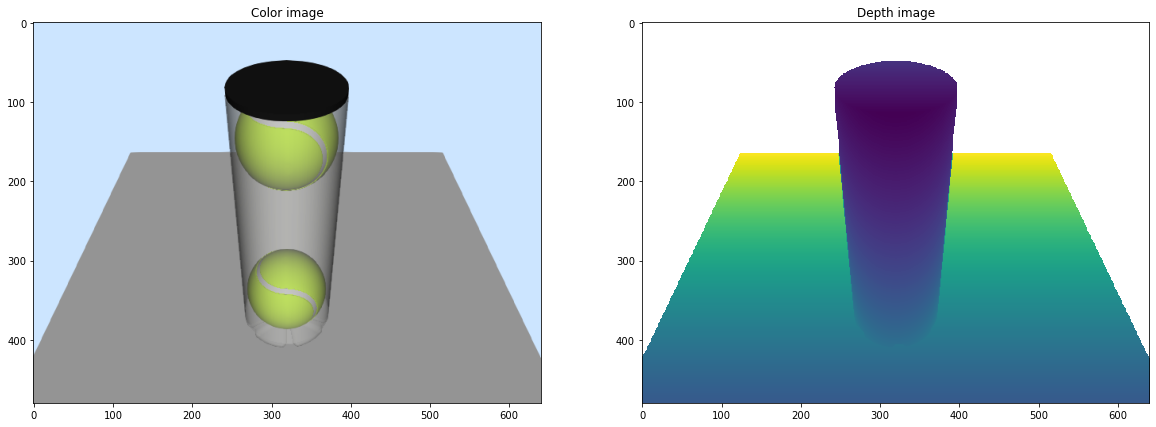

In [42]:
def plot_camera_images():
    # Evaluate the camera output ports to get the images.
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    # for i in range():
    color_image = diagram.GetOutputPort(f"rgb_image3").Eval(context)
    depth_image = diagram.GetOutputPort(f"depth_image3").Eval(context)

    # Plot the two images.
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title("Color image")
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title("Depth image")
    # mpld3.display()
    plt.show()

plot_camera_images()

In [12]:
# Take a pointcloud snapshot of the scene with the bottle.
_, diagram = setup_manipulation_station(bottle=True)
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)
scene_pcl_drake = diagram.GetOutputPort("point_cloud3").Eval(context)

In [51]:
def downsample_point_cloud(point_cloud, downsampling_factor=0.1):
    """
    Downsample a point cloud by randomly selecting a subset of points.

    Parameters:
    - point_cloud: numpy array of shape (3, N) representing a 3D point cloud.
    - downsampling_factor: Proportion of points to retain during downsampling (default is 0.1).

    Returns:
    - downsampled_point_cloud: numpy array of shape (3, M) representing the downsampled point cloud.
    """

    num_points_to_keep = int(point_cloud.shape[1] * downsampling_factor)
    sampled_indices = np.random.choice(point_cloud.shape[1], num_points_to_keep, replace=False)

    downsampled_point_cloud = point_cloud[:, sampled_indices]

    return downsampled_point_cloud

def fit_plane(xyzs):
    """
    Args:
      xyzs is (3, N) numpy array
    Returns:
      (4,) numpy array
    """
    center = np.mean(xyzs, axis=1)
    cxyzs = xyzs.T - center
    U, S, V = np.linalg.svd(cxyzs)
    normal = V[-1]  # last row of V
    d = -center.dot(normal)
    plane_equation = np.hstack([normal, d])
    return plane_equation
    
def ransac(
    point_cloud, model_fit_func, rng, tolerance=1e-3, max_iterations=500
):
    """
    Args:
      point_cloud is (3, N) numpy array
      tolerance is a float
      rng is a random number generator
      max_iterations is a (small) integer
      model_fit_func: the function to fit the model (point clouds)

    Returns:
      (4,) numpy array
    """
    best_ic = 0  # inlier count
    best_model = np.ones(4)  # plane equation ((4,) array)

    ##################
    N = point_cloud.shape[1]
    for i in range(max_iterations):
        random_int = rng.integers(low=0, high=N, size=3)
        seed_points = point_cloud[:,random_int]
        plane_equation = model_fit_func(seed_points)
        def distance_point_to_plane(point, plane_equation):
            A = plane_equation[0]
            B = plane_equation[1]
            C = plane_equation[2]
            D = plane_equation[3]

            x = point[0]
            y = point[1]
            z = point[2]

            distance = np.abs(A*x + B*y + C*z + D)/np.sqrt(A**2 + B**2 + C**2)
            return distance
        distances = np.apply_along_axis(distance_point_to_plane, 0, point_cloud, plane_equation)
        inlier_count = (distances < tolerance).sum()
        if inlier_count > best_ic:
            best_ic = inlier_count
            best_model = plane_equation

    ##################

    return best_ic, best_model

def remove_plane(point_cloud, ransac, rng, tol=2e-2):
    """
    Args:
        point_cloud: 3xN numpy array of points
        ransac: The RANSAC function to use (call ransac(args))
        rng is a random number generator
        tol: points less than this distance tolerance should be removed
    Returns:
        point_cloud_wo_plane: 3xN numpy array of points
    """
    inlier_count, ransac_plane = ransac(point_cloud, fit_plane, rng, max_iterations=100)
    def plane_points(point, plane_equation):
        A = plane_equation[0]
        B = plane_equation[1]
        C = plane_equation[2]
        D = plane_equation[3]

        x = point[0]
        y = point[1]
        z = point[2]

        return np.sqrt((A*x)**2 + (B*y)**2 + (C*z)**2 + D)
    distances = np.apply_along_axis(plane_points, 0, point_cloud, ransac_plane)
    point_cloud_wo_plane = point_cloud[:,distances >= tol]
    return point_cloud_wo_plane

meshcat.Delete()
rng = np.random.default_rng(135)  # random number generator
xyzs = np.copy(scene_pcl_drake.xyzs())
xyzs[~np.isfinite(xyzs)] = 0
xyzs_downsampled = downsample_point_cloud(xyzs, 0.01)
# meshcat.SetObject(
#     "pcl_bottle",
#     ToPointCloud(xyzs_downsampled)
# )
pcl_bottle = remove_plane(xyzs_downsampled, ransac, rng)

meshcat.SetObject(
    "pcl_bottle",
    ToPointCloud(pcl_bottle)
)